In [1]:
%load_ext autoreload
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import csv
import json
import os 
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import shutil
from importlib import reload
from IPython.display import Image, display, HTML
import matplotlib.gridspec as gridspec
import mpld3
import pprint 
pp = pprint.PrettyPrinter(indent=4)

from matplotlib.ticker import MaxNLocator
import config
import utils

import raw_log_types
import results
import tasks
import task_results
from main import VbsVis
import plot

from constants import *

In [2]:
#

# Positioned vs unpositioned

In [3]:


import csv

def plot_cumul(file, label, title, legend_labels=["FRAME: PQ", "FRAME: UQ", "VIDEO: PQ", "VIDEO: UQ"]):
    num_frames = 1154038
    pos = []
    unpos = []
    pos_v = []
    unpos_v = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')

        i = 0
        for row in csv_reader:
            i += 1
            if i == 1:
                continue
            else:
                pos_v.append(int(row[2]))
                pos.append(int(row[3]))
                unpos_v.append(int(row[4]))
                unpos.append(int(row[5]))                


    pos_v.append(num_frames)
    unpos_v.append(num_frames)
    pos.append(num_frames)
    unpos.append(num_frames)

    pos_v.append(1)
    unpos_v.append(1)
    pos.append(1)
    unpos.append(1)

    xs_pos = np.array(sorted(pos))
    ys_pos = np.arange(0, len(xs_pos))
    ys_pos[-1] = ys_pos[-2]
    xs_uppos = np.array(sorted(unpos))
    ys_unpos = np.arange(0, len(xs_pos))
    ys_unpos[-1] = ys_unpos[-2]

    
    xs_pos_v = np.array(sorted(pos_v))
    ys_pos_v = np.arange(0, len(xs_pos))
    ys_pos_v[-1] = ys_pos_v[-2]
    xs_uppos_v = np.array(sorted(unpos_v))
    ys_unpos_v = np.arange(0, len(xs_pos))
    ys_unpos_v[-1] = ys_unpos_v[-2]

    # pp.pprint(xs_pos_v)
    # pp.pprint(ys_unpos_v)

    plt.tight_layout()
    fig, ax = plt.subplots(figsize=(5,5))

    plt.rcParams["font.family"] = "stixgeneral"
    plt.rcParams["mathtext.fontset"] = "stix"
    #ax.set_title(f"{title}", y=1.0, fontsize=20, loc='right')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.xaxis.set_ticks_position('bottom')

    # Set y axis range
    ax.set_ylim(0, len(ys_unpos_v) - 1)
    ax.set_xticks([10,100,1000,10000,100000,100000])
    #ax.set_yticks([10,100,1000,10000,100000,100000])
    #ax.set_xticks([])
    #ax.set_xlim(xmin=1, xmax=1000000)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    ax.set_xscale("log")

    ax.set_xlabel("Rank R", fontsize=15)
    ax.set_ylabel("Number of found items up to rank R", fontsize=15)

    #
    # Frames
    #
    ax.step(xs_pos, ys_pos, "r", where='post', label=legend_labels[0], linewidth=2, alpha=0.5)
    ax.step(xs_uppos, ys_unpos, 'r--',where='post',  label=legend_labels[1], linewidth=2, alpha=0.5)

    #
    # Video
    #
    ax.step(xs_pos_v, ys_pos_v, "b",where='post',  label=legend_labels[2], linewidth=2, alpha=0.5)
    ax.step(xs_uppos_v, ys_unpos_v, 'b--',where='post',  label=legend_labels[3], linewidth=2, alpha=0.5)

    plt.legend(loc="lower right", fontsize=15)

    plt.savefig(os.path.join(config.out_dir("positioned"), label + "-cumul.pdf"))
    plt.show()

In [4]:

def plot_scatter(file, label, title, 
    legend_labels=["VIDEO", "SCENE"],
    axes_labels=['Rank of POSITIONED query', 'Rank of UNPOSITIONED query']
    ):

    pos = []
    unpos = []
    pos_v = []
    unpos_v = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')

        i = 0
        for row in csv_reader:
            i += 1
            if i == 1:
                continue
            else:
                pos_v.append(int(row[2]))
                pos.append(int(row[3]))
                unpos_v.append(int(row[4]))
                unpos.append(int(row[5]))                


    xs_pos = np.array(sorted(pos))
    xs_uppos = np.array(sorted(unpos))

    
    xs_pos_v = np.array(sorted(pos_v))
    xs_uppos_v = np.array(sorted(unpos_v))

    # pp.pprint(xs_pos_v)
    # pp.pprint(ys_unpos_v)

    plt.tight_layout()
    fig, ax = plt.subplots(figsize=(5,5))

    plt.rcParams["font.family"] = "stixgeneral"
    plt.rcParams["mathtext.fontset"] = "stix"
    #ax.set_title(f"{title}", y=1.0, fontsize=20, loc='right')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))    
    ax.xaxis.set_ticks_position('bottom')

    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    ax.set_xscale("log")
    ax.set_xlabel(axes_labels[0], fontsize=15)
    ax.set_yscale("log")
    ax.set_ylabel(axes_labels[1], fontsize=15)

    #ax.set_xticks([10,100,1000,10000,100000,100000, 1000000])
    #ax.set_yticks([10,100,1000,10000,100000,100000, 1000000])

    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='k', ls='--', lw="0.5")

    #
    # Frames
    #
    ax.scatter(xs_pos_v, xs_uppos_v, label=legend_labels[0], alpha=0.5, marker='x', c="b")

    #
    # Video
    #
    ax.scatter(xs_pos, xs_uppos, label=legend_labels[1], alpha=0.5, marker='x', c="r")

    plt.legend(loc="lower right", fontsize=15)

    plt.savefig(os.path.join(config.out_dir("positioned"), label + "-scatter.pdf"))
    plt.show()

<Figure size 432x288 with 0 Axes>

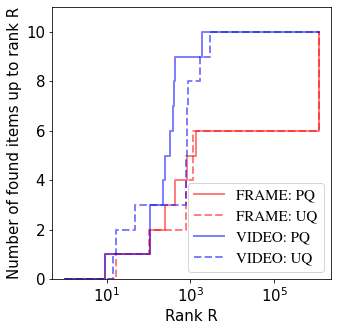

<Figure size 432x288 with 0 Axes>

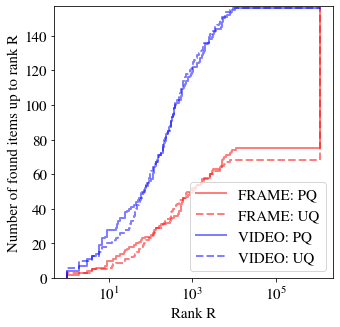

<Figure size 432x288 with 0 Axes>

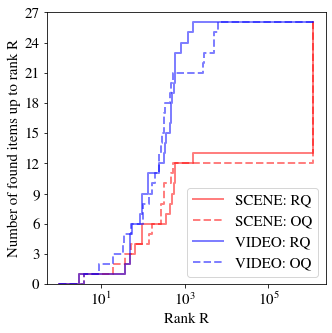

In [5]:
file = config.get_loc_dic("text-canvas")
plot_cumul(file, "text-canvas", "Text canvas queries")

file = config.get_loc_dic("bitmap-canvas")
plot_cumul(file, "bitmap-canvas", "Bitmap canvas queries")

file = config.get_loc_dic("relocation")
plot_cumul(file, "relocation", "Relocation queries", legend_labels=["SCENE: RQ", "SCENE: OQ", "VIDEO: RQ", "VIDEO: OQ"])


<Figure size 432x288 with 0 Axes>

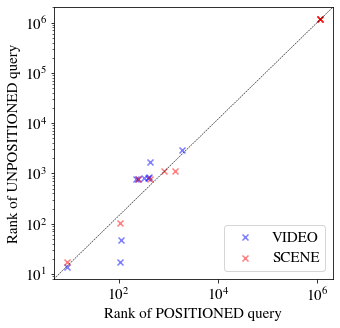

<Figure size 432x288 with 0 Axes>

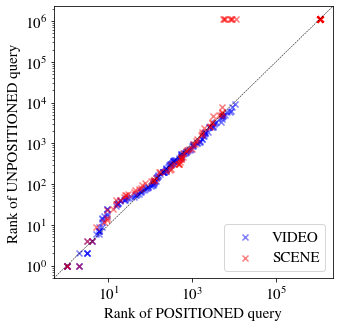

<Figure size 432x288 with 0 Axes>

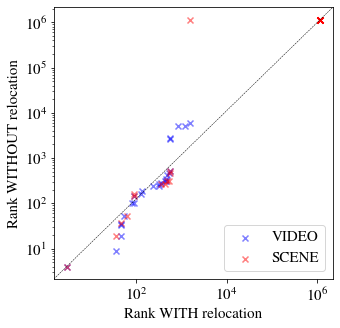

In [6]:
file = config.get_loc_dic("text-canvas")
plot_scatter(file, "text-canvas", "Text canvas queries")

file = config.get_loc_dic("bitmap-canvas")
plot_scatter(file, "bitmap-canvas", "Bitmap canvas queries")

file = config.get_loc_dic("relocation")
plot_scatter(file, "relocation", "Relocation queries", axes_labels=["Rank WITH relocation", "Rank WITHOUT relocation"])


NameError: name 'tasks_ALL' is not defined

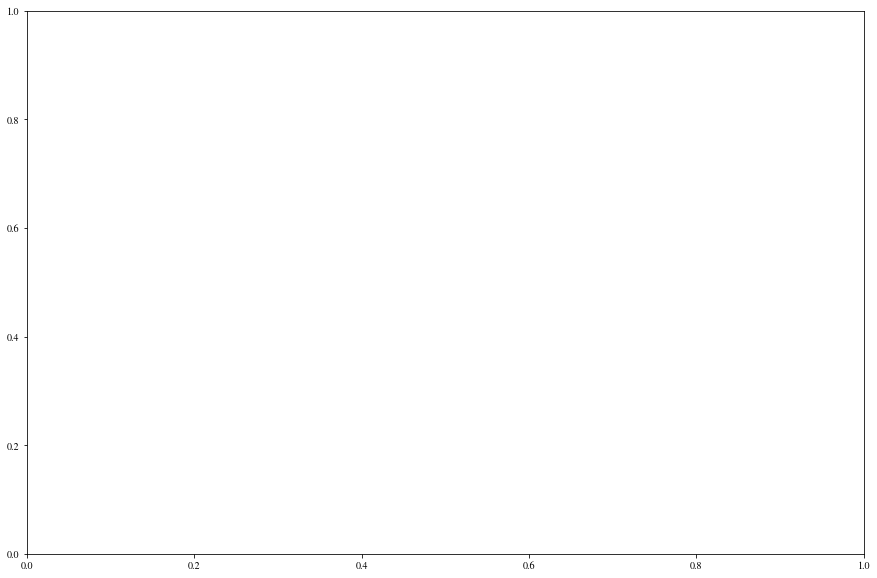

In [7]:
def get_time_to_heatmap_data():
    times = []
    with open(time_to_corr_submit_file) as ifs:
        csv_reader = csv.reader(ifs, delimiter=',')

        i = 0
        for row in csv_reader:
            # First line are usually column names
            if i == 0:
                print(f'Column names are {", ".join(row)}')
            else:
                times.append(row)

        i += 1
        
    return times

all_teams = config.all_teams()

f, axes = plt.subplots(figsize=(15, 10))

num_of_rows = len(tasks_ALL) + 4
num_of_columns = len(all_teams) + 1

heat_map = np.zeros(shape=(num_of_rows, num_of_columns))

heat_map_member = np.zeros(shape=(num_of_rows, num_of_columns))

heat_vid_map = np.zeros(shape=(num_of_rows, num_of_columns))

non_zero_mask = np.zeros(shape=(num_of_rows, num_of_columns), dtype=bool)

vid_mask = np.ones(shape=(num_of_rows, num_of_columns), dtype=bool)

col_names = []
row_names = []

non_zero_mask[:, -1] = True    
non_zero_mask[-1, :] = True    

success_mask = np.ones(shape=(num_of_rows, num_of_columns), dtype=bool)
success_mask[:, -1] = False    
success_mask[-1, :] = False    

total_success_mask = np.ones(shape=(num_of_rows, num_of_columns), dtype=bool)

success_map = np.zeros(shape=(num_of_rows, num_of_columns))

total_success_map = np.zeros(shape=(num_of_rows, num_of_columns))

succ_row_i = 0
succ_row_names = ["SOLV. T", "SOLV. V-E", "SOLV. V-N"]


teamIndex = 0
for teamId in all_teams:
    col_names.append(team_number_to_shortname[teamId])
    taskIndex = 0
    last_part_sum = 0
    for task_list in [tasks_KIS_textual, tasks_KIS_visual_exp, tasks_KIS_visual_nov]:
        for test_task in sorted(task_list, key=lambda tsk: tsk['startTimeStamp']):
            if teamIndex == 0:
                row_names.append("$" + old_task_name_to_new_tex[test_task['name']] + "$")
            test_task_id = test_task["_id"]
            test_task_start = int(test_task["startTimeStamp"])
            test_task_end = int(test_task["endTimeStamp"])
            video_number = test_task["videoRanges"][0]["videoNumber"]

            test_task_id_lower = test_task_id.lower()

            for memberId in range(1,3):
                if (test_task_id_lower, teamId, memberId) in tasks_resolution_time:
                    heat_map[taskIndex, teamIndex] = tasks_resolution_time[(test_task_id_lower, teamId, memberId)]
                    heat_map_member[taskIndex, teamIndex] = memberId
                    break
            else:
                non_zero_mask[taskIndex, teamIndex] = True
            
            if heat_map[taskIndex, teamIndex] == 0:
                video_sub = 999
                for memId in range(1, 3):
                    if (test_task_id, teamId, memId) in submissions_by_team_and_task:
                        temp_subs = list(map(lambda sub: sub['searchTime'], 
                                             filter(lambda sub: sub['videoNumber'] == video_number, submissions_by_team_and_task[(test_task_id, teamId, memId)])))
                        if len(temp_subs) > 0:
                            video_sub = min(temp_subs + [video_sub])
                            if video_sub == min(temp_subs):
                                heat_map_member[taskIndex, teamIndex] = memId
                        
                if video_sub != 999:
                    heat_vid_map[taskIndex, teamIndex] = video_sub
                    vid_mask[taskIndex, teamIndex] = False
            
            taskIndex += 1
    
        non_zero_mask[taskIndex, :] = True   
        success_mask[taskIndex, :] = False  

        for i in range(len(all_teams)):
            # print("last_part_sum", last_part_sum, "taskIndex", taskIndex)
            success_map[taskIndex, i] = np.count_nonzero(heat_map[last_part_sum : taskIndex, i]) / len(heat_map[last_part_sum : taskIndex, i])
            
        success_map[taskIndex, -1] = np.count_nonzero(heat_map[last_part_sum : taskIndex, :-1]) / (heat_map[last_part_sum : taskIndex, :-1].shape[0] * heat_map[last_part_sum : taskIndex, :-1].shape[1])
        
        taskIndex += 1
        last_part_sum = taskIndex
        
        
        if teamIndex == 0:
            row_names.append(succ_row_names[succ_row_i])
            succ_row_i += 1
    
    teamIndex += 1

    
part_sum_rows = [i for i, r in enumerate(row_names) if "SOLV" in r]
    
for i in range(len(all_teams)):
    success_map[-1, i] = np.count_nonzero(heat_map[:-1, i]) / (len(heat_map[:-1, i]) - 3)
    
    
for i in range(len(tasks_ALL) + 3):
    if i not in part_sum_rows:
        success_map[i, -1] = np.count_nonzero(heat_map[i, :-1]) / (len(heat_map[i, :-1]))
    else:
        total_success_map[i, -1] = success_map[i, -1]
        success_map[i, -1] = 0
        total_success_mask[i, -1] = False
        success_mask[i, -1] = True

        
total_success_map[-1, -1] = np.count_nonzero(heat_map[:-1, :-1]) / ((heat_map[:-1, :-1].shape[0] - 3) * heat_map[:-1, :-1].shape[1])
total_success_mask[-1, -1] = False
success_mask[-1, -1] = True
        
success_map *= 100
total_success_map *= 100
    
def get_member_marker(m):
    if m == 1:
        return "$s_{(1)}$"
    return "$s_{(2)}$"
    
heat_annots = (np.asarray(["{:.0f}{}".format(string, get_member_marker(mem)) for string, mem in zip(heat_map.flatten(), heat_map_member.flatten())])
             ).reshape(heat_map.shape)
    
ax = sns.heatmap(pd.DataFrame(heat_map, columns=col_names + ["SOLVED"], index=row_names + ["SOLV. ALL"]),
                 annot=heat_annots, linewidth=0.5, ax=axes, fmt="s", mask=non_zero_mask, cmap = sns.light_palette((125, 60, 80), input="husl", reverse=True), cbar = False)

if True:

    success_annots = (np.asarray(["{:.0f}\%".format(string) for string in success_map.flatten()])
                 ).reshape(success_map.shape)

    ax = sns.heatmap(pd.DataFrame(success_map, columns=col_names + ["SOLVED"], index=row_names + ["SOLV. ALL"]),
                     annot=success_annots, linewidth=0.5, ax=axes, fmt="s", mask=success_mask, cmap = sns.light_palette((125, 10, 60), input="husl", reverse=False), cbar = False)

if True:

    total_success_annots = (np.asarray(["{:.0f}\%".format(string) for string in total_success_map.flatten()])
                 ).reshape(total_success_map.shape)

    ax = sns.heatmap(pd.DataFrame(total_success_map, columns=col_names + ["SOLVED"], index=row_names + ["SOLV. ALL"]),
                     annot=total_success_annots, linewidth=0.5, ax=axes, fmt="s", mask=total_success_mask, cmap = sns.light_palette((230, 100, 83), input="husl", reverse=False), cbar = False)

if True:

    heat_vid_annots = (np.asarray(["{:.0f}{}".format(string, get_member_marker(mem)) for string, mem in zip(heat_vid_map.flatten(), heat_map_member.flatten())])
                 ).reshape(heat_vid_map.shape)

    ax = sns.heatmap(pd.DataFrame(heat_vid_map, columns=col_names + ["SOLVED"], index=row_names + ["SOLV. ALL"]), annot_kws={"color": "red"},
                     annot=heat_vid_annots, linewidth=0.5, ax=axes, fmt="s", mask=vid_mask, cmap = ListedColormap(['white']), cbar = False)


plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = True, labeltop=True, labelleft = True, left = True)
plt.yticks(rotation=0) 
plt.xticks(rotation=0)

ax.hlines([0, len(tasks_ALL) + 3] + [i for i, r in enumerate(row_names) if "SOLV" in r] + [i + 1 for i, r in enumerate(row_names) if "SOLV" in r], *ax.get_xlim())

ax.vlines(range(len(all_teams) + 1), *ax.get_ylim())


f.tight_layout()
plt.savefig(config.out_dir() + "/out/submissions.pdf")